In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
from math import ceil, floor

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
from utils_summary_statistics import *
import configs
from Fig3_run_resolution_sweep import param_sweep_search_strengths

# Choose experiment to load

In [2]:
# Specify what you're looking at
exp = 'rec_strength'
model_type = 'default'

In [3]:
if os.environ['USER'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/barcodes/' # Local Path
elif 'SLURM_JOBID' in os.environ.keys():
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/barcodes/' # Axon Path
else:
    engram_dir = '/home/cf2794/engram/Ching/barcodes/' # Cortex Path
exp_dir = os.path.join(engram_dir, 'resolution', exp, model_type)

In [4]:
N_inp = 5000
N_bar = 5000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [5]:
truncate = False

In [6]:
summary_stats = {
    'identification_1': None, 'identification_2': None,
    'identification_3': None, 'identification_4': None,
    'reconstruct_1': None, 'reconstruct_2': None,
    'reconstruct_3': None, 'activations_1': None, 'activations_2': None
    }

for param in os.listdir(exp_dir):
    if param == '.DS_Store': continue
    dirpath = os.path.join(exp_dir, param)
    for site_spacing in os.listdir(dirpath):
        if not site_spacing.startswith('res'): continue    
        dirpath = os.path.join(exp_dir, param, site_spacing)
        for seed in os.listdir(dirpath):
            if not seed.startswith('seed'): continue
            dirpath = os.path.join(exp_dir, param, site_spacing, seed)
            _param = round(float(param), 1)
            _seed = int(seed[4:])
            _site_spacing = int(site_spacing[3:])
            if truncate and (_seed > 5 or _param > 9.0): continue
            cache_states = [0, _site_spacing, 66]
            
            try:
                with open(os.path.join(dirpath, 'results.p'), 'rb') as f:
                    _results = pickle.load(f)
            except:
                continue
                
            for s in param_sweep_search_strengths:
                readout = np.linalg.norm(_results[f'{s:.2f}_reconstruct'], axis=1)
                readout /= readout.max()
                reconstruct = _results[f'{s:.2f}_reconstruct'].copy()
                activations = _results[f'{s:.2f}_acts'].copy()
                _summary_stats = get_resolution_summary_statistics(
                    readout, reconstruct, cache_states, activations,
                    inputs, _site_spacing, search_strength=s)
                for key, _dict in _summary_stats.items():
                    n_samples = len(_dict[list(_dict.keys())[0]])
                    _dict['rec strength'] = [_param]*n_samples
                    if summary_stats[key] is None:
                        summary_stats[key] == _dict
                    else:
                        for nested_key in _dict.keys():
                            summary_stats[key][nested_key].extend(_dict[nested_key])

/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:132: RuntimeWarning: invalid value encountered in greater
  valid = np.logical_and(readout>0.5, np.isin(peak_locs, cache_states))
/share/ctn/users/cf2794/Code/barcodes/utils_summary_statistics.py:142: RuntimeWarning: invalid value encountered in true_divide
  r = reconstruct[idx]/reconstruct[idx].max()
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/linalg/linalg.py:2480: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in 

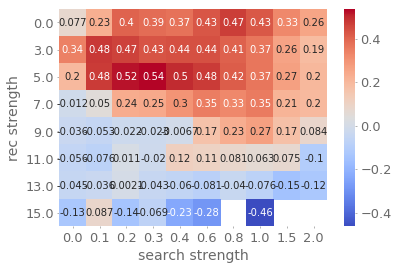

In [61]:
df = pd.DataFrame(identification_1)
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'score')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

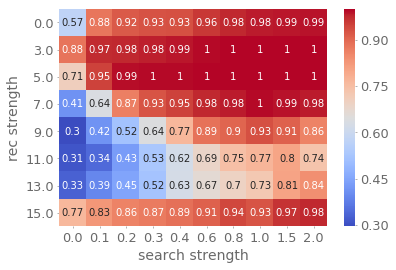

In [64]:
df = pd.DataFrame(identification_2)
df = df[df['threshold']==0.5]
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'sensitivity')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

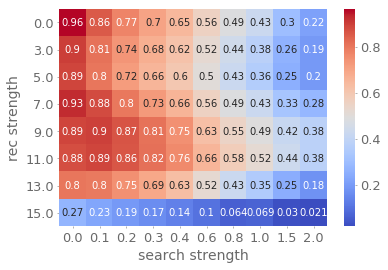

In [65]:
df = pd.DataFrame(identification_2)
df = df[df['threshold']==0.5]
df = df.groupby(['rec strength', 'search strength']).mean().reset_index()
heatmap_data = df.pivot('rec strength', 'search strength', 'specificity')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.show()

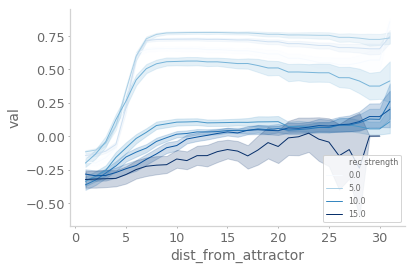

In [41]:
df = pd.DataFrame(identification_4)
fig, ax = plt.subplots()
sns.lineplot(
    x='dist_from_attractor', y ='val',
    hue='rec strength', data=df[df['search strength']==0.2],
    palette='Blues'
    )

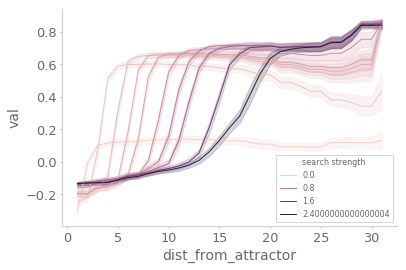

In [42]:
df = pd.DataFrame(identification_4)
fig, ax = plt.subplots()
sns.lineplot(
    x='dist_from_attractor', y ='val',
    hue='search strength', data=df[df['rec strength']==0]
    )

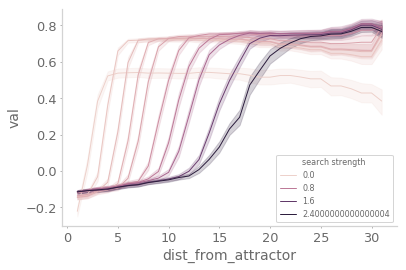

In [43]:
df = pd.DataFrame(identification_4)
fig, ax = plt.subplots()
sns.lineplot(
    x='dist_from_attractor', y ='val',
    hue='search strength', data=df[df['rec strength']==3.0]
    )

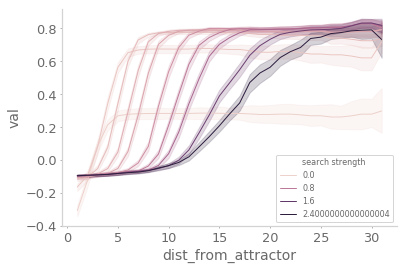

In [44]:
df = pd.DataFrame(identification_4)
fig, ax = plt.subplots()
sns.lineplot(
    x='dist_from_attractor', y ='val',
    hue='search strength', data=df[df['rec strength']==5.0]
    )

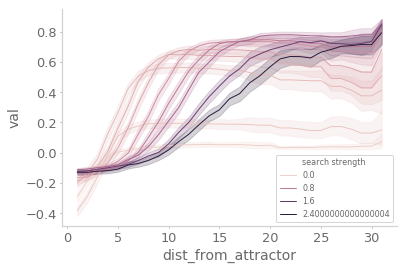

In [45]:
df = pd.DataFrame(identification_4)
fig, ax = plt.subplots()
sns.lineplot(
    x='dist_from_attractor', y ='val',
    hue='search strength', data=df[df['rec strength']==7.0]
    )

In [ ]:
def get_reconstruct_stats(reconstruct):
    argmax_v = np.argmax(reconstruct, axis=1)
    argmax_v = (argmax_v/N_inp)*num_states
    max_v = np.max(reconstruct, axis=1)
    threshold_scale = 1.
    threshold = reconstruct.mean()+threshold_scale*reconstruct.std()

    attractor_dist = []
    opt_attractor_dist = []
    attractor_locs = []
    attractor_validity = []
    state_locs = []
    for loc, _v in enumerate(argmax_v):
        if max_v[loc] < threshold:
            _v = -1
        _opt_dist = min([distance(loc, c, num_states) for c in cache_states])
        opt_attractor_dist.append(_opt_dist)
        state_locs.append(loc)
        if _v in cache_states:
            attractor_dist.append(distance(loc, _v, num_states))
            if _opt_dist > distance(loc, _v, num_states):
                import pdb; pdb.set_trace()
            attractor_locs.append(_v)
            attractor_validity.append(1)
        else:
            attractor_dist.append(np.nan)
            attractor_locs.append(np.nan)
            attractor_validity.append(-1)
    attractor_dist = np.array(attractor_dist)
    attractor_locs = np.array(attractor_locs)
    attractor_validity = np.array(attractor_validity)
    opt_attractor_dist = np.array(opt_attractor_dist)
    state_locs = np.array(state_locs)
    return attractor_dist, attractor_locs, attractor_validity, opt_attractor_dist, state_locs


In [ ]:
results_1 = {
    'param': [],
    'seed': [],
    'valid_attractors': [],
    'valid_20_30_attractors': [],
    }
results_2A = {
    'param': [],
    'seed': [],
    'opt attractor dist': [],
    'probability': []
    }
results_2B = {
    'param': [],
    'seed': [],
    'opt attractor dist': [],
    'chosen attractor dist': []
    }
results_2C = {
    'param': [],
    'seed': [],
    'cache': [],
    'probability': [],
    }
results_3 = {
    'param': [],
    'seed': [],
    'distance': [],
    'barcode corr': []
    }
results_4 = {
    'param': [],
    'seed': [],
    'place-barcode corr': []
    }

for param in os.listdir(exp_dir):
    if param == '.DS_Store': continue
    for seed in os.listdir(exp_dir + param):
        if seed == '.DS_Store': continue
        _exp_dir = exp_dir + param + '/' + seed + '/'
        with open(_exp_dir + 'results.p', 'rb') as f:
            _results = pickle.load(f)
        attractor_dist, attractor_locs, attractor_validity, opt_attractor_dist, state_locs = \
            get_reconstruct_stats(_results[f'{search_style}_reconstruct'])
        
        # Test 1
        valid = np.sum(attractor_validity==1)/attractor_validity.size
        v = attractor_validity[np.logical_and(state_locs>20, state_locs<30)]
        valid_20_30 = np.sum(v==1)/v.size
        results_1['param'].append(float(param))
        results_1['seed'].append(seed)
        results_1['valid_attractors'].append(valid)
        results_1['valid_20_30_attractors'].append(valid_20_30)
        
        # Test 2A
        for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
            idxs = opt_attractor_dist==_opt_dist
            _validity = attractor_validity[idxs]
            valid = np.sum(_validity==1)/_validity.size
            results_2A['param'].append(float(param))
            results_2A['seed'].append(seed)
            results_2A['opt attractor dist'].append(_opt_dist)
            results_2A['probability'].append(valid)
            
        # Test 2B
        attractor_dist = attractor_dist[attractor_validity==1]
        attractor_locs = attractor_locs[attractor_validity==1]
        opt_attractor_dist = opt_attractor_dist[attractor_validity==1]
        for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
            idxs = opt_attractor_dist==_opt_dist
            _chosen_dist = np.mean(attractor_dist[idxs]) - _opt_dist
            results_2B['param'].append(float(param))
            results_2B['seed'].append(seed)
            results_2B['opt attractor dist'].append(_opt_dist)
            results_2B['chosen attractor dist'].append(_chosen_dist)
            
        # Test 2C
        for idx, cache_state in enumerate(cache_states):
            p = np.sum(attractor_locs==cache_state)/attractor_locs.size
            results_2C['param'].append(float(param))
            results_2C['seed'].append(seed)
            results_2C['cache'].append(cache_state)
            results_2C['probability'].append(p)
            
        # Test 3
        acts = _results[f'{search_style}_acts']
        c = pairwise_correlations_centered(acts)
        distances = []; correlations = []
        for i in range(c.shape[0]):
            for j in range(c.shape[1]):
                distances.append(distance(i, j, num_states))
                correlations.append(c[i,j])
        distances = np.array(distances); correlations = np.array(correlations)
        for _dist in np.unique(distances):
            idxs = distances==_dist
            _corr = np.mean(correlations[idxs])
            results_3['param'].append(float(param))
            results_3['seed'].append(seed)
            results_3['distance'].append(_dist)
            results_3['barcode corr'].append(_corr)
            
        # Test 4
        acts_normalized = normalize(acts)
        inputs_normalized = normalize(inputs)
        corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
        results_4['param'].append(float(param))
        results_4['seed'].append(seed)
        results_4['place-barcode corr'].append(np.mean(corrs))